This notebook must be run in an environment where graphviz is installed

In [1]:
import toml
import joblib
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from os.path import join
from itertools import product
from collections import defaultdict
from rl_analysis.plotting import save_factory, setup_plotting_env

In [2]:
with open("../analysis_configuration.toml", "r") as f:
    config = toml.load(f)

In [3]:
setup_plotting_env()
saver = save_factory(join(config['figures']['store_dir'], 'fig-s02'), tight_layout=False)
plt.rcParams['figure.dpi'] = 300

In [4]:
def weights_transform(val, maximum=1e-1):
    return val ** 2.25 if val > maximum else 0


tms = joblib.load(join(config['intermediate_results']['misc'], 'fig_s2-binned-tms.p'))
_sorting = joblib.load(join(config['intermediate_results']['misc'], 'fig_s2-syllable-sorting.p'))

g = defaultdict(list)
weights = defaultdict(list)
ebunch = defaultdict(list)
# threshold = 5e-2 # don't plot outgoing transition probabilities above this
threshold = 1e-1
eps = 1e-5

for k, _trans in enumerate(tms):

    _trans += eps
    _trans /= _trans.sum(axis=1, keepdims=True)

    r, c = np.where(_trans > threshold)
    for i, j in product(*(range(len(_trans)), ) * 2):
        p = _trans[i, j]
        p = p if p > threshold else 0
        ebunch[k] += [(_sorting[i], _sorting[j], p)]

    g[k] = nx.MultiDiGraph()
    g[k].add_weighted_edges_from(ebunch[k])
    weights[k] = np.array([weights_transform(_trans[_sorting.index(u), _sorting.index(v)], threshold) for u, v in g[k].edges()])
    edge_list = list(g[k].edges(keys=True))

In [5]:
degree_sequence = np.argsort([d for n, d in list(g.values())[0].degree()])
node_sorting = degree_sequence

In [ ]:
compare_key = list(g.keys())[0]
pos = nx.nx_agraph.graphviz_layout(list(g.values())[0], prog="circo")

In [13]:
node_colors = ["b" for _ in pos.keys()]
node_sizes = [10 for _ in pos.keys()]

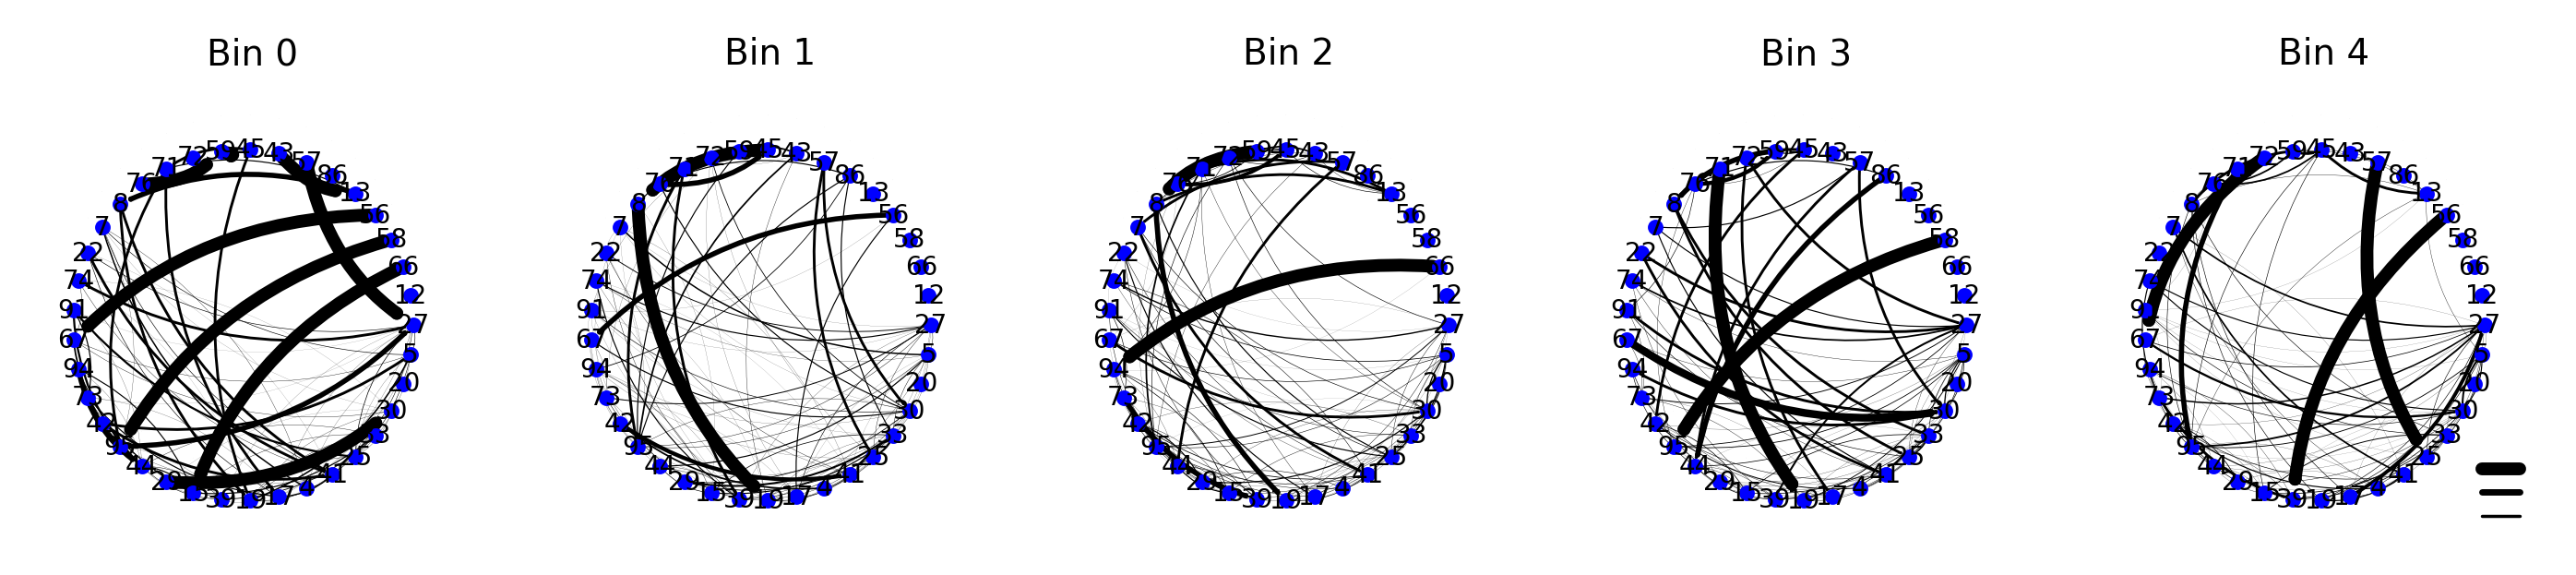

In [16]:
width_scale = 2.5
fig, ax = plt.subplots(1, len(g), figsize=(8.75, 1.56), sharex=True, sharey=True)
fig.dpi = 200
for _ax, (_k, _g) in zip(ax, g.items()):
    nx.draw(
        _g,
        pos,
        node_color="b",
        edge_color="k",
        width=np.maximum(weights[_k] * width_scale, 0),
        node_size=5,
        ax=_ax,
        arrows=True,
        arrowsize=0.1,
        connectionstyle="arc3, rad=.2",
        with_labels=True,
        font_size=5,
    )
    _ax.axis("off")
    _ax.set_title(f"Bin {_k}")

# make a legend
ylimits = _ax.get_ylim()
xlimits = _ax.get_xlim()

# show levels
levels = [0.25, 0.5, 1]

xedge = xlimits[1] * 0.9
xlen = xlimits[1] - xedge

ypos = ylimits[0] + (ylimits[1] - ylimits[0]) * 0.05
yinc = 100

for _level in levels:
    _ax.plot([xedge, xedge + xlen], [ypos, ypos], lw=_level * width_scale, clip_on=False, color="k")
    ypos += yinc

saver(fig, "binned-circular-tm-graphs");